In [1]:
from etl.spark_initializer import SparkInitializer
from etl.extractor.extractor import DataFrameExtractor
from etl.tranform.transform import CustomerDataTransformer,PurchaseHistoryDataTransformer,ProductDataTransformer
from etl.validator_data import ValidatorImpl
from etl.load.loader import LoadDataToMysql
import os
from etl.sql_executor import MysqlExecutor
from etl.report.customer_report import CustomerReport
from etl.report.product_report import ProductReport
from etl.report.purchase_report import PurchaseReport

In [2]:
# Set SPARK_CLASSPATH to include JARs
os.environ["SPARK_CLASSPATH"] = os.path.abspath("jars/hadoop-aws-3.3.4.jar") + ";" + os.path.abspath("jars/aws-java-sdk-bundle-1.12.262.jar")

# Reset and initialize Spark session
SparkInitializer._spark = None
spark = SparkInitializer.get_spark()

**Extractor**

In [3]:
# Extract data from CSV files
fas_purchase_df = (DataFrameExtractor()
                    .extract_from_csv('csv', 'dataset/fashion_purchase_history.csv'))

customer_df = (DataFrameExtractor()
                    .extract_from_csv('csv', 'dataset/customer.csv'))

product_df = (DataFrameExtractor()
                    .extract_from_csv('csv', 'dataset/products.csv'))

In [ ]:
# Extract data from S3 with error handling
try:
    fas_purchase_df = (DataFrameExtractor()
                        .extract('csv', 'raw/fashion_purchase_history.csv'))
    print("Successfully loaded fashion purchase data")
    fas_purchase_df.show(3)
    
    customer_df = (DataFrameExtractor()
                        .extract('csv', 'raw/customer.csv'))
    print("Successfully loaded customer data")
    customer_df.show(3)
    
    product_df = (DataFrameExtractor()
                        .extract('csv', 'raw/products.csv'))
    print("Successfully loaded product data")
    product_df.show(3)
    
except Exception as e:
    print(f"Error loading data from S3: {str(e)}")
    import traceback
    traceback.print_exc()

Successfully loaded fashion purchase data
+-----------+--------------+---------------+--------+-------------+-------------+--------------+
|customer_id|item_purchased|purchase_amount|quantity|date_purchase|review_rating|payment_method|
+-----------+--------------+---------------+--------+-------------+-------------+--------------+
|       4115|         Tunic|         2456.0|       3|   2023-07-11|          2.0|   Credit Card|
|       4019|      Tank Top|         2102.0|       2|   2023-03-23|          4.1|          Cash|
|       4097|      Leggings|         3126.0|       4|   2023-03-15|          3.2|          Cash|
+-----------+--------------+---------------+--------+-------------+-------------+--------------+
only showing top 3 rows

Successfully loaded customer data
+-----------+----------+---------+------+-------------------+--------------------+------------+-------------------+------------+-----------+
|customer_id|first_name|last_name|gender|      date_of_birth|               ema

**Transfrom**

In [8]:
# kiểm tra kiểu dữ liệu
print('\033[1m' +'-- Data type: -- ')
customer_df.printSchema()
fas_purchase_df.printSchema()
product_df.printSchema()

# Check missing value
print('\033[1m' + '-- Null: -- ')
ValidatorImpl().check_null_values(customer_df)
ValidatorImpl().check_null_values(fas_purchase_df)
ValidatorImpl().check_null_values(product_df)

# Check duplicate value
print('\033[1m' +'-- Duplicate values: -- ')
ValidatorImpl().check_duplicate_records(customer_df,['customer_id', 'first_name', 'last_name', 'gender', 'date_of_birth'])
ValidatorImpl().check_duplicate_records(fas_purchase_df,['customer_id', 'item_purchased', 'date_purchase'])
ValidatorImpl().check_duplicate_records(product_df,['item', 'category'])

-- Data type: -- 
root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date_of_birth: timestamp (nullable = true)
 |-- email: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- signup_date: timestamp (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)

root
 |-- customer_id: integer (nullable = true)
 |-- item_purchased: string (nullable = true)
 |-- purchase_amount: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- date_purchase: date (nullable = true)
 |-- review_rating: double (nullable = true)
 |-- payment_method: string (nullable = true)

root
 |-- item: string (nullable = true)
 |-- category: string (nullable = true)

-- Null: -- 
+-----------+----------+---------+------+-------------+-----+------------+-----------+-------+----+
|customer_id|first_name|last_name|gender|date_of

In [4]:
'''
Change data type:
    - date_of_birth: TimeStamp -> Date
    - date_purchase: Date -> Timestamp
    - review_rating: Double -> Floatx
'''
cleand_customer_df = CustomerDataTransformer().transform(customer_df)

cleand_fas_purchase_df = PurchaseHistoryDataTransformer().transform(fas_purchase_df)

cleand_product_df = ProductDataTransformer().transform(product_df)

In [10]:
# Check data type
cleand_customer_df.printSchema()
cleand_fas_purchase_df.printSchema()
cleand_product_df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = false)
 |-- last_name: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- date_of_birth: date (nullable = true)
 |-- email: string (nullable = false)
 |-- phone_number: string (nullable = false)
 |-- signup_date: timestamp (nullable = true)
 |-- address: string (nullable = false)
 |-- city: string (nullable = false)

root
 |-- customer_id: integer (nullable = true)
 |-- item_purchased: string (nullable = true)
 |-- purchase_amount: double (nullable = false)
 |-- quantity: integer (nullable = true)
 |-- date_purchase: timestamp (nullable = true)
 |-- review_rating: float (nullable = false)
 |-- payment_method: string (nullable = true)

root
 |-- item: string (nullable = true)
 |-- category: string (nullable = false)



In [11]:
# Check duplicate value
print('\033[1m' +'-- Duplicate values: -- ')
ValidatorImpl().check_duplicate_records(cleand_customer_df,['customer_id', 'first_name', 'last_name', 'gender', 'date_of_birth'])
ValidatorImpl().check_duplicate_records(cleand_fas_purchase_df,['customer_id', 'item_purchased', 'date_purchase'])
ValidatorImpl().check_duplicate_records(cleand_product_df,['item', 'category'])


-- Duplicate values: -- 
+-----------+----------+---------+------+-------------+---------------+
|customer_id|first_name|last_name|gender|date_of_birth|duplicate_count|
+-----------+----------+---------+------+-------------+---------------+
+-----------+----------+---------+------+-------------+---------------+

+-----------+--------------+-------------+---------------+
|customer_id|item_purchased|date_purchase|duplicate_count|
+-----------+--------------+-------------+---------------+
+-----------+--------------+-------------+---------------+

+----+--------+---------------+
|item|category|duplicate_count|
+----+--------+---------------+
+----+--------+---------------+



**Load to db**

In [12]:
cleand_customer_df.show(3)
cleand_fas_purchase_df.show(3)
cleand_product_df.show(3)

+-----------+----------+---------+------+-------------+--------------------+------------+-------------------+-------------+-------+
|customer_id|first_name|last_name|gender|date_of_birth|               email|phone_number|        signup_date|      address|   city|
+-----------+----------+---------+------+-------------+--------------------+------------+-------------------+-------------+-------+
|       3964|      Alex|  Johnson|Female|   1972-07-14|robert.williams87...|291-285-3647|2017-09-17 14:04:33|  7255 Oak St|Phoenix|
|       3970|      Alex|    Jones|Female|   1981-10-08|jane.williams34@m...|869-802-7565|2015-07-10 17:08:42|5623 Maple St|Chicago|
|       3995|      Alex|    Jones|  Male|   1997-02-05|sarah.martinez133...|924-800-7391|2019-09-13 14:21:15| 5180 Main St|Houston|
+-----------+----------+---------+------+-------------+--------------------+------------+-------------------+-------------+-------+
only showing top 3 rows

+-----------+--------------+---------------+-------

In [9]:
## Create customer, product and puchase_history_stagging table 
sql_statements =[
    """
    CREATE TABLE customer(
        customer_id INT PRIMARY KEY AUTO_INCREMENT,
        first_name VARCHAR(20),
        last_name VARCHAR(20),
        gender VARCHAR(10),
        date_of_birth DATE,
        email VARCHAR(50),
        phone_number VARCHAR(12),
        signup_date TIMESTAMP, 
        address VARCHAR(255),
        city VARCHAR(50)    
    )
    """,
    """
    CREATE TABLE product (
        item VARCHAR(50) PRIMARY KEY,
        category VARCHAR(50)
    )
    """,
    """
    CREATE TABLE purchase_history_stagging (
        purchase_id INT PRIMARY KEY AUTO_INCREMENT,
        customer_id INT,
        item_purchased VARCHAR(50),
        purchase_amount DOUBLE,
        quantity INT,
        date_purchase TIMESTAMP,
        review_rating FLOAT,
        payment_method VARCHAR(15)
       )   
    """    
]
message = '✅ Creation table success!' 
error_message = '❌ Error:'
for statement in sql_statements:
    try:
        MysqlExecutor().execute([statement], message, error_message)
    except Exception as e:
        print(f"Error executing statement: {statement}")
        print(f"Error details: {e}")
        break

✅ Creation table success!
✅ Creation table success!
✅ Creation table success!


In [10]:
# Load data to Mysql database
db_config = {
    'mode': 'append',
    'jdbc_url': 'jdbc:mysql://localhost:3306/walmart'
}
connection_properties = {
    'user': 'root',
    'password': '12345',
    'driver': 'com.mysql.cj.jdbc.Driver'
}

customer_table_name = 'customer'
LoadDataToMysql().load_to_db(cleand_customer_df, customer_table_name, db_config, connection_properties)

product_table_name = 'product'
LoadDataToMysql().load_to_db(cleand_product_df, product_table_name, db_config, connection_properties)

purchase_table_name = 'purchase_history_stagging'
LoadDataToMysql().load_to_db(cleand_fas_purchase_df, purchase_table_name, db_config, connection_properties)

In [11]:
'''
    Checking referential integrity: 
        purchase_history và product
        purchase_history và customer
'''
missing_product = cleand_fas_purchase_df.join(
    cleand_product_df,
    cleand_fas_purchase_df.item_purchased == cleand_product_df.item,
    'left_anti'
)
missing_product.show()

+-----------+--------------+---------------+--------+-------------------+-------------+--------------+
|customer_id|item_purchased|purchase_amount|quantity|      date_purchase|review_rating|payment_method|
+-----------+--------------+---------------+--------+-------------------+-------------+--------------+
|       3958|         Tunic|           64.0|       4|2023-06-17 00:00:00|          1.1|          Cash|
|       3962|        Poncho|          184.0|       3|2023-09-25 00:00:00|          2.6|          Cash|
|       3963|        Poncho|          184.0|       2|2023-03-02 00:00:00|          1.6|   Credit Card|
|       3965|        Poncho|          176.0|       1|2023-09-28 00:00:00|          3.6|          Cash|
|       3970|         Tunic|          166.0|       1|2023-02-02 00:00:00|          3.1|   Credit Card|
|       3972|         Tunic|          126.0|       3|2022-11-08 00:00:00|          3.8|   Credit Card|
|       3976|         Tunic|          140.0|       4|2022-12-31 00:00:00|

In [12]:
cleand_customer_df.show()

+-----------+----------+---------+------+-------------+--------------------+------------+-------------------+-------------+------------+
|customer_id|first_name|last_name|gender|date_of_birth|               email|phone_number|        signup_date|      address|        city|
+-----------+----------+---------+------+-------------+--------------------+------------+-------------------+-------------+------------+
|       3964|      Alex|  Johnson|Female|   1972-07-14|robert.williams87...|291-285-3647|2017-09-17 14:04:33|  7255 Oak St|     Phoenix|
|       3970|      Alex|    Jones|Female|   1981-10-08|jane.williams34@m...|869-802-7565|2015-07-10 17:08:42|5623 Maple St|     Chicago|
|       3995|      Alex|    Jones|  Male|   1997-02-05|sarah.martinez133...|924-800-7391|2019-09-13 14:21:15| 5180 Main St|     Houston|
|       4009|      Alex|  Johnson|Female|   1987-09-21|linda.johnson91@m...|178-578-8949|2022-04-10 18:14:58|    45 Oak St|     Houston|
|       4032|      Alex|    Jones|  Male|

In [13]:
missing_customer = cleand_fas_purchase_df.join(
    cleand_customer_df,
    cleand_fas_purchase_df.customer_id == cleand_customer_df.customer_id ,
    'left_anti'
)
missing_customer.show()

+-----------+--------------+---------------+--------+-------------+-------------+--------------+
|customer_id|item_purchased|purchase_amount|quantity|date_purchase|review_rating|payment_method|
+-----------+--------------+---------------+--------+-------------+-------------+--------------+
+-----------+--------------+---------------+--------+-------------+-------------+--------------+



In [14]:

# Create purchase_history table
sql_statement=["""
    CREATE TABLE purchase_history 
    SELECT ph.* 
    FROM purchase_history_stagging AS ph
    JOIN Product AS p 
    ON ph.item_purchased = p.item;
    """,
    
    """
    ALTER TABLE purchase_history
    ADD CONSTRAINT fk_customer_id 
    FOREIGN KEY (customer_id) 
    REFERENCES customer(customer_id) 
    ON DELETE CASCADE;
    """,
    
    """
    ALTER TABLE purchase_history
    ADD CONSTRAINT fk_item_purchased 
    FOREIGN KEY (item_purchased) 
    REFERENCES product(item) 
    ON DELETE CASCADE;   
    """
]

message = '✅ Creation table success!' 
error_message = '❌ Error:'
MysqlExecutor().execute(sql_statement, message, error_message)

✅ Creation table success!


Save to s3 as parquet

In [16]:
try:
    LoadDataToMysql().load_to_s3(
        cleand_fas_purchase_df, 
        'fashion_purchase.parquet'
        )
    
    LoadDataToMysql().load_to_s3(
        cleand_customer_df, 
        'customer.parquet'
        )
    LoadDataToMysql().load_to_s3(
        cleand_product_df, 
        'product.parquet'
        )
except Exception as e:
    print(e)

Data successfully saved to S3 as Parquet at: s3a://walmartbucketpj/parquet_data/fashion_purchase.parquet/
Data successfully saved to S3 as Parquet at: s3a://walmartbucketpj/parquet_data/customer.parquet/
Data successfully saved to S3 as Parquet at: s3a://walmartbucketpj/parquet_data/product.parquet/


**Report**

Total Products: 50
         category  count
0         Dresses      4
1       Outerwear      7
2   Miscellaneous      2
3            Tops      8
4        Swimwear      1
5         Unknown      1
6        Footwear      6
7       Sleepwear      2
8         Bottoms      5
9     Accessories     13
10         Unknow      1


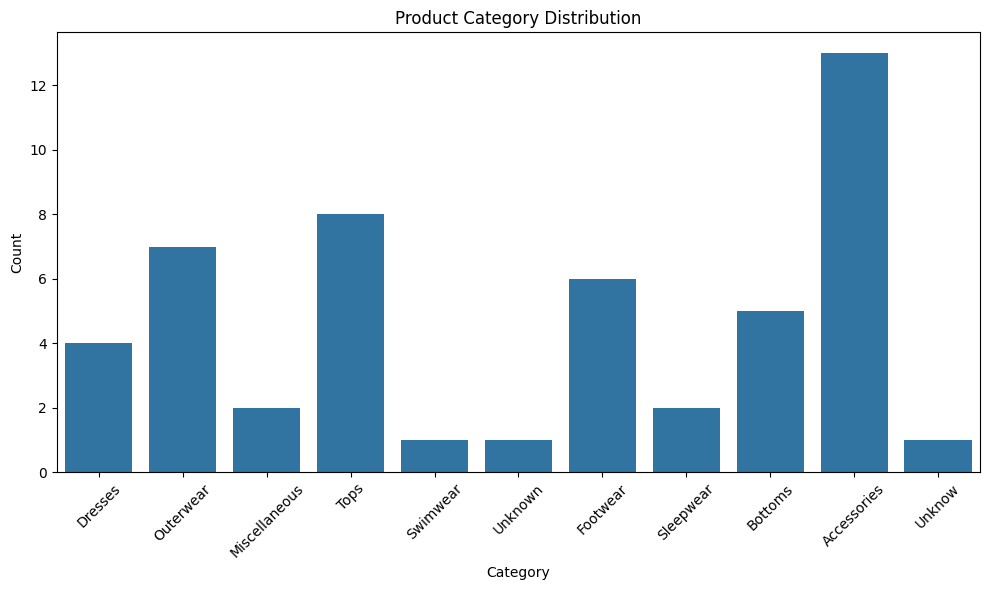

✅ Report exported to reports/reports/category_distribution.xlsx


In [5]:
# Generate product report overview
ProductReport(cleand_product_df).generate_overview()


Total Customers: 166
   gender  count
0  Female     94
1   Other      1
2    Male     71


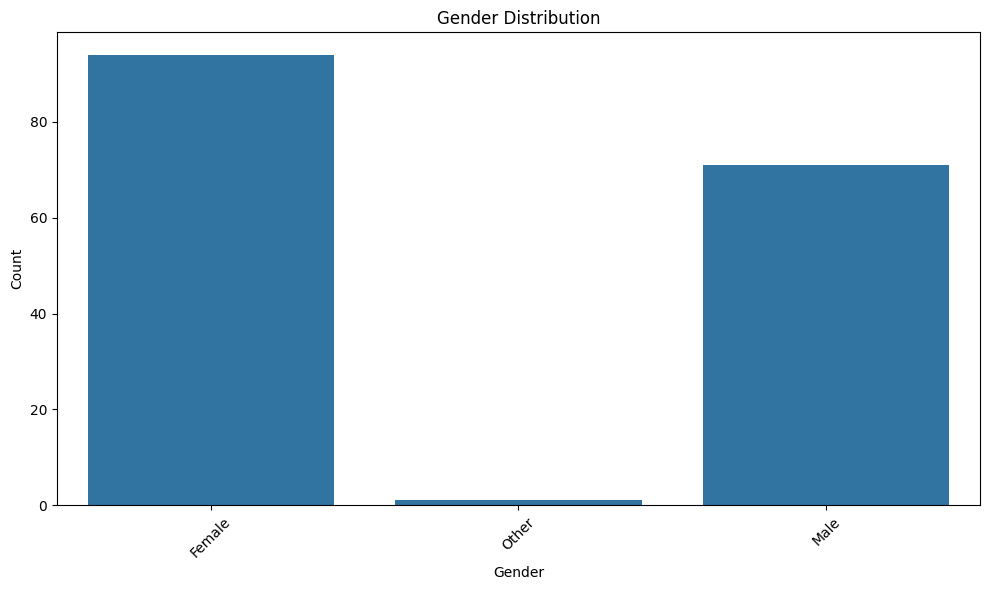

✅ Report exported to reports/reports/gender_distribution.xlsx


In [ ]:
# Generate customer report overview
CustomerReport(cleand_customer_df).generate_overview()

Total Purchases: 2485
Total Revenue: 371054.0
   Rank  customer_id  total_spent
0     1         4044       8745.0
1     2         4075       7067.0
2     3         4108       6828.0
3     4         4067       6528.0
4     5         4040       6519.0
5     6         3984       6327.0
6     7         4002       6320.0
7     8         4099       6002.0
8     9         3986       5908.0
9    10         3976       5845.0


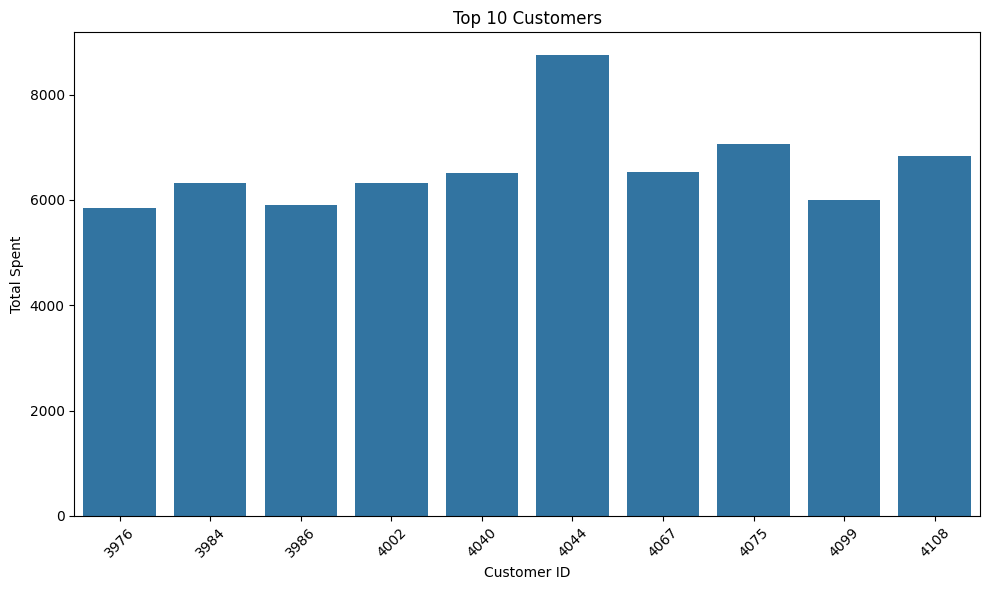

✅ Report exported to reports/reports/top_customers.xlsx


In [7]:
# Generate puchase report overview
PurchaseReport(cleand_fas_purchase_df).generate_overview()

# Generate top customers report
PurchaseReport(cleand_fas_purchase_df).top_customers()